In [1]:
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# functions

In [13]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

# loading model

In [3]:
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
models = pd.Series([f for f in os.listdir(models_dir) if f.find('Legacy')==-1])
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024-11-09 112825652640 cboe spx relative asian
1     2024-11-09 124653897492 cboe spx relative barrier


In [4]:
selected_model = models.iloc[1]
model_dir = os.path.join(models_dir,selected_model)
pickle = [f for f in os.listdir(model_dir) if f.endswith('.pkl')][0]
picke_dir = os.path.join(model_dir,pickle)
model = joblib.load(picke_dir)
model

{'seed': 1312,
 'raw_data':          spot_price  strike_price  barrier  days_to_maturity updown outin  \
 0            1274.0        1146.6    637.0                60   Down   Out   
 1            1274.0        1146.6    637.0                60   Down   Out   
 2            1274.0        1146.6    637.0                60   Down    In   
 3            1274.0        1146.6    637.0                60   Down    In   
 4            1274.0        1146.6    637.0                90   Down   Out   
 ...             ...           ...      ...               ...    ...   ...   
 4067275      5857.0        6442.7   8785.5               540     Up    In   
 4067276      5857.0        6442.7   8785.5               720     Up   Out   
 4067277      5857.0        6442.7   8785.5               720     Up   Out   
 4067278      5857.0        6442.7   8785.5               720     Up    In   
 4067279      5857.0        6442.7   8785.5               720     Up    In   
 
             w barrier_type_name  r

In [5]:
print('model attributes:\n')
for k in model.keys():
    print(k)

model attributes:

seed
raw_data
dataset
target_name
excluded_features
numerical_features
categorical_features
feature_set
n_features
development_dates
test_dates
train_data
test_data
train_X
train_y
test_X
test_y
preprocessor
pipeline
model
model_fit
dnn_runtime
numerical_scaler
dnn_params
transformers
regressor
dnn_pipeline


In [6]:
for col in model['feature_set']:
    print(f"{col.replace("_"," ")}:",f"\n{model['test_data'][col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()

days to maturity: 
0     60
1     90
2    180
3    360
4    540
5    720
Name: days_to_maturity, dtype: int64

dividend rate: 
0       0.012624
1       0.012628
2       0.012641
3       0.012671
4       0.012687
          ...   
1152    0.023672
1153    0.023681
1154    0.023780
1155    0.023823
1156    0.024133
Name: dividend_rate, Length: 1157, dtype: float64

risk free rate: 
0      0.000330
1      0.000355
2      0.000380
3      0.000406
4      0.000431
         ...   
781    0.054494
782    0.054500
783    0.054513
784    0.054801
785    0.054889
Name: risk_free_rate, Length: 786, dtype: float64

theta: 
0       8.181674e-11
1       4.564269e-10
2       4.968155e-10
3       6.916618e-10
4       1.119760e-09
            ...     
1747    1.700398e+00
1748    1.732709e+00
1749    1.811241e+00
1750    1.836051e+00
1751    1.869788e+00
Name: theta, Length: 1752, dtype: float64

kappa: 
0       3.553361e-10
1       3.924365e-10
2       7.518568e-10
3       8.464905e-10
4       1.055398e

In [7]:
train_data = model['train_data'].copy()
test_data = model['test_data'].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'],format='mixed')
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'],format='mixed')
test_data = test_data.set_index('calculation_date').sort_index()
train_data = train_data.set_index('calculation_date').sort_index()
print(model['feature_set'])

['days_to_maturity', 'dividend_rate', 'risk_free_rate', 'theta', 'kappa', 'rho', 'eta', 'v0', 'relative_spot', 'relative_barrier', 'relative_rebate', 'w', 'barrier_type_name']


# retraining

In [8]:
from convsklearn import convsklearn
help(convsklearn)

Help on class convsklearn in module convsklearn.convsklearn:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object



In [9]:
test_dates = model['test_dates']
full_dataset = model['dataset']
pricename = [f[:f.find('_',0)] for f in full_dataset.columns if f.find('asian_price')!=-1 or f.find('barrier_price')!=-1][0]
all_dates = full_dataset['date'].drop_duplicates().sort_values().reset_index(drop=True)
all_dates

0      2012-01-03
1      2012-01-05
2      2012-01-06
3      2012-01-10
4      2012-01-18
          ...    
1409   2024-09-24
1410   2024-10-07
1411   2024-10-08
1412   2024-10-09
1413   2024-10-14
Name: date, Length: 1414, dtype: datetime64[ns]

In [10]:
retraining_frequency = 30
retraining_dates = test_dates.iloc[0::retraining_frequency]
retraining_dates = retraining_dates.reset_index(drop=True)

cols = ['cpu','insample_MAE','insample_RMSE','outofsample_MAE','outofsample_RMSE']
df = pd.DataFrame(np.tile(np.nan,(len(retraining_dates),len(cols))),columns=cols,index=retraining_dates)

models = {}

retrainer_base = convsklearn()
retrainer_base.excluded_features += model['excluded_features']
retrainer_base.target_name = model['target_name']
retrainer_base.load_data(full_dataset)

bar = tqdm(total=len(retraining_dates),leave=True)
for date in retraining_dates:
    print(date)
    development_dates = all_dates[all_dates<=date]
    subset_test_dates = all_dates[~all_dates.isin(development_dates)].iloc[:retraining_frequency]
    retrainer = retrainer_base
    print(f"training:  {min(development_dates).strftime('%A, %d %B, %Y')}  -  {max(development_dates).strftime('%A, %d %B, %Y')} ({len(development_dates)} trading days)")
    print(f"testing:   {min(subset_test_dates).strftime('%A, %d %B, %Y')}  -  {max(subset_test_dates).strftime('%A, %d %B, %Y')} ({len(subset_test_dates)} trading days)")
    retrainer.preprocess_data(development_dates, subset_test_dates,plot=False)
    retrainer.run_dnn(print_details=True)
    retrainer.test_prediction_accuracy()
    models[date] = retrainer.__dict__
    m = retrainer.__dict__
    df.at[date,'cpu'] = m['dnn_runtime']
    df.at[date,'insample_MAE'] = compute_MAE(m['train_data']['insample_error'])
    df.at[date,'insample_RMSE'] = compute_RMSE(m['train_data']['insample_error'])
    df.at[date,'outofsample_MAE'] = compute_MAE(m['test_data']['outofsample_error'])
    df.at[date,'outofsample_RMSE'] = compute_RMSE(m['test_data']['outofsample_error'])
    print(df.dropna())
    print('\n','%'*10,'\n')
    bar.update(1)
bar.close()

  0%|                                                                                                                                                                                     | 0/44 [00:00<?, ?it/s]

2012-11-06 00:00:00
training:  Tuesday, 03 January, 2012  -  Tuesday, 06 November, 2012 (101 trading days)
testing:   Thursday, 08 November, 2012  -  Friday, 22 March, 2013 (30 trading days)

training on 268941 samples...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
random_state: 1312
cpu: 57.86224818229675


  2%|███▉                                                                                                                                                                         | 1/44 [00:58<41:47, 58.31s/it]


in sample:
     RMSE: 0.0155463925008248
     MAE: 0.009653831727588923

out of sample:
     RMSE: 0.06803331708071107
     MAE: 0.023977838594117902
                  cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                  
2012-11-06  57.862248      0.009654       0.015546         0.023978   

            outofsample_RMSE  
date                          
2012-11-06          0.068033  

 %%%%%%%%%% 

2013-03-22 00:00:00
training:  Tuesday, 03 January, 2012  -  Friday, 22 March, 2013 (131 trading days)
testing:   Tuesday, 26 March, 2013  -  Monday, 10 June, 2013 (30 trading days)

training on 358041 samples...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
random_state: 1312
cpu: 78.64110350608826


  5%|███████▊                                                                                                                                                                     | 2/44 [02:17<49:24, 70.58s/it]


in sample:
     RMSE: 0.014768462310316616
     MAE: 0.009204596553839345

out of sample:
     RMSE: 0.09131353550084434
     MAE: 0.028433728421179236
                  cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                  
2012-11-06  57.862248      0.009654       0.015546         0.023978   
2013-03-22  78.641104      0.009205       0.014768         0.028434   

            outofsample_RMSE  
date                          
2012-11-06          0.068033  
2013-03-22          0.091314  

 %%%%%%%%%% 

2013-06-10 00:00:00
training:  Tuesday, 03 January, 2012  -  Monday, 10 June, 2013 (161 trading days)
testing:   Wednesday, 12 June, 2013  -  Thursday, 29 August, 2013 (30 trading days)

training on 433101 samples...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
random_state: 1312
cpu: 110.60697770118

  7%|███████████▋                                                                                                                                                               | 3/44 [04:08<1:00:55, 89.15s/it]


in sample:
     RMSE: 0.013174333704412315
     MAE: 0.008066376456901878

out of sample:
     RMSE: 0.05829185103492043
     MAE: 0.016714210932100387
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   

            outofsample_RMSE  
date                          
2012-11-06          0.068033  
2013-03-22          0.091314  
2013-06-10          0.058292  

 %%%%%%%%%% 

2013-08-29 00:00:00
training:  Tuesday, 03 January, 2012  -  Thursday, 29 August, 2013 (191 trading days)
testing:   Monday, 09 September, 2013  -  Monday, 18 November, 2013 (30 trading days)

training on 521661 samples...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
sol

  9%|███████████████▍                                                                                                                                                          | 4/44 [06:10<1:08:01, 102.04s/it]


in sample:
     RMSE: 0.012106834760522402
     MAE: 0.007388693728062532

out of sample:
     RMSE: 0.022906469874282874
     MAE: 0.008700240083612785
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   

            outofsample_RMSE  
date                          
2012-11-06          0.068033  
2013-03-22          0.091314  
2013-06-10          0.058292  
2013-08-29          0.022906  

 %%%%%%%%%% 

2013-11-18 00:00:00
training:  Tuesday, 03 January, 2012  -  Monday, 18 November, 2013 (221 trading days)
testing:   Thursday, 21 November, 2013  -  Friday, 14 February, 2014 (30 trading days)

training on 598827

 11%|███████████████████▎                                                                                                                                                      | 5/44 [08:51<1:20:12, 123.39s/it]


in sample:
     RMSE: 0.013716460455963343
     MAE: 0.008465828106514873

out of sample:
     RMSE: 0.07790404167734967
     MAE: 0.02449723932707823
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   

            outofsample_RMSE  
date                          
2012-11-06          0.068033  
2013-03-22          0.091314  
2013-06-10          0.058292  
2013-08-29          0.022906  
2013-11-18          0.077904  

 %%%%%%%%%% 

2014-02-14 00:00:00
training:  Tuesday, 03 January, 2012  -  Friday, 14 February, 2014 (251 trading days)
testi

 14%|███████████████████████▏                                                                                                                                                  | 6/44 [11:09<1:21:08, 128.13s/it]


in sample:
     RMSE: 0.01624564549649192
     MAE: 0.01021841370026935

out of sample:
     RMSE: 0.04527912671545104
     MAE: 0.014823417884159442
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   

            outofsample_RMSE  
date                          
2012-11-06          0.068033  
2013-03-22          0.091314  
2013-06-10          0.058292  
2013-08-29          0.022906  
2013-11-18          0.077904  
2014-02-14          0.045279  

 %%%%%%%%%% 

2014-06-0

 16%|███████████████████████████                                                                                                                                               | 7/44 [14:27<1:33:10, 151.09s/it]


in sample:
     RMSE: 0.0138488427500832
     MAE: 0.008266915134387601

out of sample:
     RMSE: 0.03561305633042726
     MAE: 0.010750398986350053
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   

            outofsample_RMSE  
date                          
2012-11-06          0.068033  
2013-03-22          0.091314  
2013-06-10          0.058292  
2013-08-29          0.022906  
2013-11-18    

 18%|██████████████████████████████▉                                                                                                                                           | 8/44 [17:18<1:34:30, 157.51s/it]


in sample:
     RMSE: 0.01726220174952849
     MAE: 0.008799866171018644

out of sample:
     RMSE: 0.04969173265310787
     MAE: 0.016823769873773608
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   

            outofsample_RMSE  
date                          
2012-11-06          0.068033  
2013-03-22          0.091314  
201

 20%|██████████████████████████████████▊                                                                                                                                       | 9/44 [20:55<1:42:36, 175.90s/it]


in sample:
     RMSE: 0.0137964380328597
     MAE: 0.008156902356813066

out of sample:
     RMSE: 0.06542181920965438
     MAE: 0.022310605184654515
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   

            outofsample_RMSE  
date                     

 23%|██████████████████████████████████████▍                                                                                                                                  | 10/44 [24:12<1:43:22, 182.42s/it]


in sample:
     RMSE: 0.013914753331509235
     MAE: 0.0076666145444144965

out of sample:
     RMSE: 0.07183052461103158
     MAE: 0.026026097694280794
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915   

 25%|██████████████████████████████████████████▎                                                                                                                              | 11/44 [27:58<1:47:42, 195.83s/it]


in sample:
     RMSE: 0.013924609419502085
     MAE: 0.008385723007242584

out of sample:
     RMSE: 0.036158854630508185
     MAE: 0.013988910960027913
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915   

 27%|██████████████████████████████████████████████                                                                                                                           | 12/44 [33:41<2:08:21, 240.66s/it]


in sample:
     RMSE: 0.014178364149195743
     MAE: 0.00763469794813111

out of sample:
     RMSE: 0.10674344985978451
     MAE: 0.03698617778782845
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915      

 30%|█████████████████████████████████████████████████▉                                                                                                                       | 13/44 [39:03<2:17:05, 265.35s/it]


in sample:
     RMSE: 0.01773906552089186
     MAE: 0.008151712164163261

out of sample:
     RMSE: 0.02744425120748084
     MAE: 0.012047879831487262
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915     

 32%|█████████████████████████████████████████████████████▊                                                                                                                   | 14/44 [45:18<2:29:15, 298.51s/it]


in sample:
     RMSE: 0.017264576605783816
     MAE: 0.00820838564712242

out of sample:
     RMSE: 0.01209953822698082
     MAE: 0.0077243072193045135
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915    

 34%|█████████████████████████████████████████████████████████▌                                                                                                               | 15/44 [50:43<2:28:05, 306.41s/it]


in sample:
     RMSE: 0.014730273817396248
     MAE: 0.007754958571173452

out of sample:
     RMSE: 0.05105906448470865
     MAE: 0.01749664536694528
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915     

 36%|█████████████████████████████████████████████████████████████▍                                                                                                           | 16/44 [57:01<2:33:03, 327.99s/it]


in sample:
     RMSE: 0.01533396700472386
     MAE: 0.007239104931400106

out of sample:
     RMSE: 0.011889344695577894
     MAE: 0.0069939608360373
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915      

 39%|████████████████████████████████████████████████████████████████▌                                                                                                      | 17/44 [1:01:19<2:18:07, 306.93s/it]


in sample:
     RMSE: 0.10181999819112424
     MAE: 0.05766643541237698

out of sample:
     RMSE: 0.0931289888586138
     MAE: 0.053829307744683856
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915       

 41%|████████████████████████████████████████████████████████████████████▎                                                                                                  | 18/44 [1:06:44<2:15:20, 312.31s/it]


in sample:
     RMSE: 0.01478415105608561
     MAE: 0.007097140169882778

out of sample:
     RMSE: 0.00952779559018704
     MAE: 0.005926181142369826
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915     

 43%|████████████████████████████████████████████████████████████████████████                                                                                               | 19/44 [1:13:56<2:25:06, 348.25s/it]


in sample:
     RMSE: 0.016010274736980957
     MAE: 0.008240235102081985

out of sample:
     RMSE: 0.021200347069291015
     MAE: 0.009811745348141186
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915   

 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                           | 20/44 [1:20:50<2:27:11, 367.99s/it]


in sample:
     RMSE: 0.01556961434648847
     MAE: 0.007661180678607669

out of sample:
     RMSE: 0.04538265666247357
     MAE: 0.01503160217693435
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915      

 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                       | 21/44 [1:28:44<2:33:14, 399.77s/it]


in sample:
     RMSE: 0.014678181901110064
     MAE: 0.007074590481729827

out of sample:
     RMSE: 0.0803723881476491
     MAE: 0.023485545357323407
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915     

 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 22/44 [1:36:43<2:35:18, 423.56s/it]


in sample:
     RMSE: 0.016494401778682968
     MAE: 0.007906149416203708

out of sample:
     RMSE: 0.046920727920031456
     MAE: 0.015166512606397762
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915   

 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 23/44 [1:44:53<2:35:13, 443.49s/it]


in sample:
     RMSE: 0.015086542730110713
     MAE: 0.00803617553326656

out of sample:
     RMSE: 0.04734963047706239
     MAE: 0.017007400413992856
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915     

 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                            | 24/44 [1:53:09<2:33:05, 459.28s/it]


in sample:
     RMSE: 0.018158236419491224
     MAE: 0.008345630871160995

out of sample:
     RMSE: 0.023627601949811165
     MAE: 0.009123106173852296
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915   

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 25/44 [2:02:07<2:32:53, 482.80s/it]


in sample:
     RMSE: 0.014617983991104849
     MAE: 0.007690071481878385

out of sample:
     RMSE: 0.01654040871115647
     MAE: 0.00882659787961813
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915     

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 26/44 [2:09:42<2:22:24, 474.72s/it]


in sample:
     RMSE: 0.016049646944271134
     MAE: 0.00847640249738239

out of sample:
     RMSE: 0.02116137150171304
     MAE: 0.01125456928441376
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915      

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 27/44 [2:19:16<2:22:52, 504.26s/it]


in sample:
     RMSE: 0.014238985456393856
     MAE: 0.007633029244487132

out of sample:
     RMSE: 0.03298353777464605
     MAE: 0.013132424929805651
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915    

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 28/44 [2:30:17<2:27:01, 551.34s/it]


in sample:
     RMSE: 0.026756975007510755
     MAE: 0.015309630616161777

out of sample:
     RMSE: 0.06912944726699928
     MAE: 0.031628408835356184
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915    

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 29/44 [2:43:29<2:35:55, 623.67s/it]


in sample:
     RMSE: 0.013651362208861786
     MAE: 0.0073776209704391705

out of sample:
     RMSE: 0.020309222378579607
     MAE: 0.01258557769054423
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915   

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 30/44 [2:54:54<2:29:49, 642.09s/it]


in sample:
     RMSE: 0.014289354158411233
     MAE: 0.007815026408500313

out of sample:
     RMSE: 0.014874759658171395
     MAE: 0.0101234276828091
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915     

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 31/44 [3:07:44<2:27:24, 680.36s/it]


in sample:
     RMSE: 0.014841792498604076
     MAE: 0.00807936503663857

out of sample:
     RMSE: 0.02957388890683553
     MAE: 0.012512503268561992
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915     

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 32/44 [3:18:02<2:12:19, 661.66s/it]


in sample:
     RMSE: 0.013975446592330465
     MAE: 0.007609901369471294

out of sample:
     RMSE: 0.1530338896733465
     MAE: 0.05399871744318328
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915      

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 33/44 [3:29:13<2:01:49, 664.50s/it]


in sample:
     RMSE: 0.015470762433381635
     MAE: 0.008280579143645227

out of sample:
     RMSE: 0.021059313349302628
     MAE: 0.00955945989057817
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915    

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 34/44 [3:41:35<1:54:37, 687.71s/it]


in sample:
     RMSE: 0.01493281000506649
     MAE: 0.0073529928241834516

out of sample:
     RMSE: 0.011292365693002787
     MAE: 0.0069600122984766625
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915  

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 35/44 [3:53:56<1:45:33, 703.73s/it]


in sample:
     RMSE: 0.0147128066814868
     MAE: 0.007727684038445748

out of sample:
     RMSE: 0.030191924626561385
     MAE: 0.013345547884064682
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915     

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 36/44 [4:06:52<1:36:42, 725.28s/it]


in sample:
     RMSE: 0.014324688587891606
     MAE: 0.007552887831887781

out of sample:
     RMSE: 0.019910221871485122
     MAE: 0.012304509872443626
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915   

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 37/44 [4:14:54<1:16:06, 652.35s/it]


in sample:
     RMSE: 0.09961653540669249
     MAE: 0.057591488708548834

out of sample:
     RMSE: 0.0634562778680755
     MAE: 0.046173458381797844
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915      

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 38/44 [4:26:10<1:05:57, 659.55s/it]


in sample:
     RMSE: 0.015051345161958584
     MAE: 0.008237532689466387

out of sample:
     RMSE: 0.01758180902039881
     MAE: 0.010651841707921723
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915    

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 39/44 [4:41:28<1:01:25, 737.05s/it]


in sample:
     RMSE: 0.014359694527920608
     MAE: 0.007860651676814987

out of sample:
     RMSE: 0.013935000912917486
     MAE: 0.009013246913921275
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915   

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 40/44 [4:55:11<50:51, 762.82s/it]


in sample:
     RMSE: 0.014602129068809946
     MAE: 0.007959999094089695

out of sample:
     RMSE: 0.01674752496955308
     MAE: 0.009292641585096939
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915    

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 41/44 [5:08:55<39:03, 781.32s/it]


in sample:
     RMSE: 0.014950839864876993
     MAE: 0.008230490439609675

out of sample:
     RMSE: 0.018257016346773545
     MAE: 0.009212303310689358
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915   

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 42/44 [5:24:01<27:16, 818.44s/it]


in sample:
     RMSE: 0.015163200418321941
     MAE: 0.008416159119804036

out of sample:
     RMSE: 0.021321252448014964
     MAE: 0.009732865943514642
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915   

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 43/44 [5:38:15<13:49, 829.25s/it]


in sample:
     RMSE: 0.01485546038639851
     MAE: 0.008002617332126915

out of sample:
     RMSE: 0.02708251872625514
     MAE: 0.010572316741276202
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915     

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [5:54:43<00:00, 483.71s/it]


in sample:
     RMSE: 0.01585168423261692
     MAE: 0.00854704429364765

out of sample:
     RMSE: 0.018238560561198547
     MAE: 0.009589239954863195
                   cpu  insample_MAE  insample_RMSE  outofsample_MAE  \
date                                                                   
2012-11-06   57.862248      0.009654       0.015546         0.023978   
2013-03-22   78.641104      0.009205       0.014768         0.028434   
2013-06-10  110.606978      0.008066       0.013174         0.016714   
2013-08-29  121.100220      0.007389       0.012107         0.008700   
2013-11-18  160.418323      0.008466       0.013716         0.024497   
2014-02-14  136.426292      0.010218       0.016246         0.014823   
2014-06-04  197.425721      0.008267       0.013849         0.010750   
2014-08-13  170.179247      0.008800       0.017262         0.016824   
2014-12-01  215.208325      0.008157       0.013796         0.022311   
2015-04-17  195.875498      0.007667       0.013915     

['cpu', 'insample_MAE', 'insample_RMSE', 'outofsample_MAE', 'outofsample_RMSE']


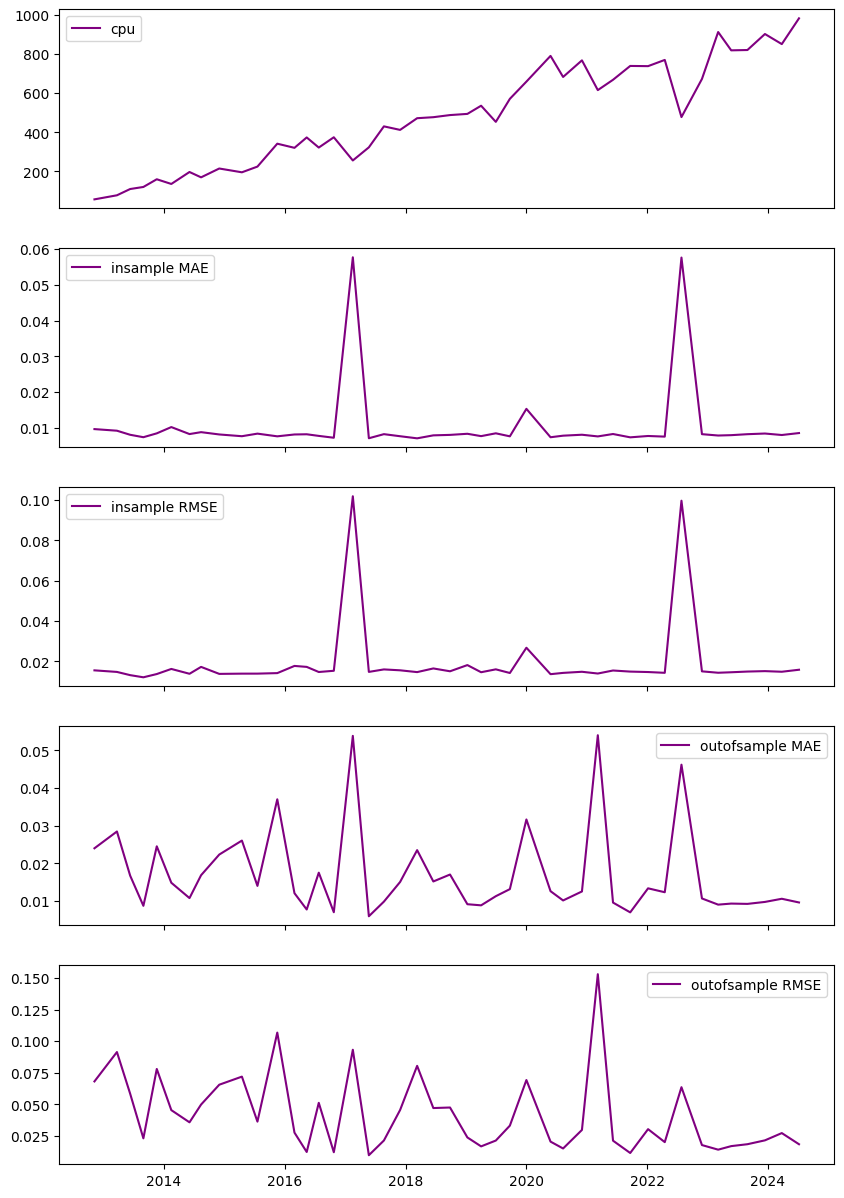

In [11]:
from plotters import PlotCols
PlotCols(df)

In [12]:
retrained = {'errors':df,'models':models}
tag = ms.timetag()
joblib.dump(retrained,f'{tag} retrained_relative_{pricename}_options.pkl')

['2024-11-09 223743847698 retrained_relative_barrier_options.pkl']